# 5. Binary operations, regions

Once a binary mask of interesting objects has been obtained e.g. by thresholding, it is often necessary to correct it. For example some object might have holes, or noisy isolated pixels should be suppressed. This is where binary operation or morphological operations are very useful. These are essentially non-linear operators that turn pixels ON/OFF depending on the local surroundings. Note that a more general class of morphological operators also exist for gray-scale.

Once a clean masks is obtained, the remaining objects can finally be analyzed both on a geometric level (area, shape etc.) and intensity level (e.g. mean intensity of an object in a given channel).

We start by importing the necessary modules, in particular the ```skimage.morphology``` module which provides  the binary operators.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
plt.gray();
import skimage.io as io

import skimage.morphology
import skimage.filters

# generate random colormap
import matplotlib
cmap = matplotlib.colors.ListedColormap (np.random.rand(256,4))
cmap.colors[:,3] = 0.5
cmap.colors[0,:] = 1
cmap.colors[0,3] = 0

<Figure size 432x288 with 0 Axes>

We now reload the image from the last chapter and apply some automatic thresholding to it to obtain a binary mask:

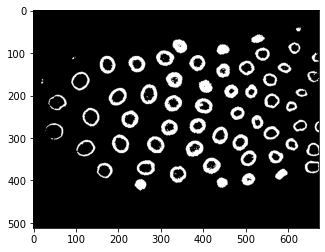

In [2]:
# load image
data = skimage.io.MultiImage('../Data/30567/30567.tif')
image = data[3]

# median filter + thresholding
image = skimage.filters.median(image,selem=np.ones((2,2)))
image_otsu_threshold = skimage.filters.threshold_otsu(image)
image_otsu = image > image_otsu_threshold
plt.imshow(image_otsu);

## 5.1 Binary filters

### 5.1.1. Dilation, erosion

Binary filters turn pixels ON (white) and OFF (black) based on their surrounding. For example we can erode or dilate the image using an area of radius 5. Erosion: If a ON pixel has a OFF neighbor in its surrounding region it becomes black (erode). Dilation: any black pixel which as a white neighbor becomes white.

Just like for regular filtering, the neighborhood is defined thanks to a *selection element*, a binary mask of a certain arbitrary shape. Let's use a disk with two different radii and erode/dilate the mask. We zoom for a moment on a cropped region of the mask:

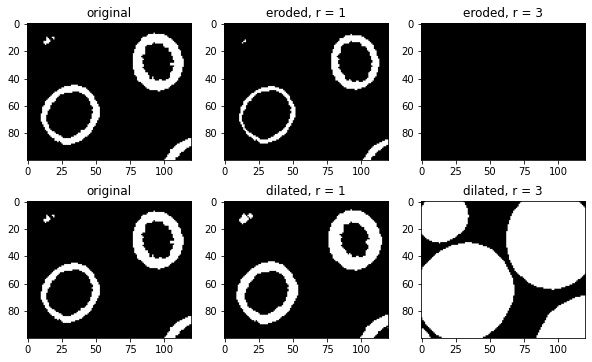

In [27]:
radius = 1
eroded1 = skimage.morphology.binary_erosion(image_otsu, selem = skimage.morphology.disk(radius))
dilated1 = skimage.morphology.binary_dilation(image_otsu, selem = skimage.morphology.disk(radius))
radius = 3
eroded2 = skimage.morphology.binary_erosion(image_otsu, selem = skimage.morphology.disk(radius))
dilated2 = skimage.morphology.binary_dilation(image_otsu, selem = skimage.morphology.disk(radius))

fig, ax = plt.subplots(2,3, figsize=(10,6))
ax[0,0].imshow(image_otsu[100:200,80:200])
ax[0,0].set_title('original')
ax[0,1].imshow(eroded1[100:200,80:200])
ax[0,1].set_title('eroded, r = 1')
ax[0,2].imshow(eroded2[100:200,80:200])
ax[0,2].set_title('eroded, r = 3')
ax[1,0].imshow(image_otsu[100:200,80:200])
ax[1,0].set_title('original')
ax[1,1].imshow(dilated1[100:200,80:200])
ax[1,1].set_title('dilated, r = 1')
ax[1,2].imshow(dilated2[100:200,80:200])
ax[1,2].set_title('dilated, r = 3');

We see two important effects of these filters: depending on the filter size, erosion can break objects (top right circle) or merge objects (top left "dust"). We thus have to be careful when choosing the scale of the filters.

### 5.1.2 Erosion/dilation combinations

Note that different filers can be applied in series. Let's for example consider this region:

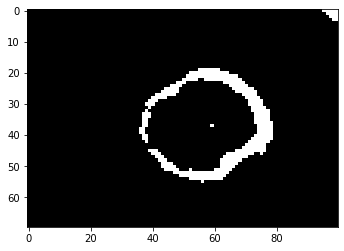

In [31]:
plt.imshow(image_otsu[180:250,0:100]);

We can first dilate the object to create a continuous ring by closing the gap where it's broken. Then we can erode it with a filter of same size to return it to its original thickness:

In [36]:
radius = 3
im_dilate = skimage.morphology.binary_dilation(image_otsu, selem = skimage.morphology.disk(radius))
im_erode = skimage.morphology.binary_erosion(im_dilate, selem = skimage.morphology.disk(radius))

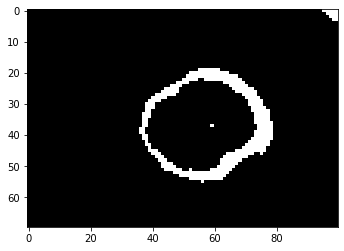

In [37]:
plt.imshow(im_erode[180:250,0:100]);

We have effectively *closed* the object. We could have done the opposite, first erosion then dilation, in order to *open* larger gaps in the object. These operations are so common that they are directly available as functions in skimage as ```skimage.morphology.binary_opening``` and ```skimage.morphology.binary_closing```:

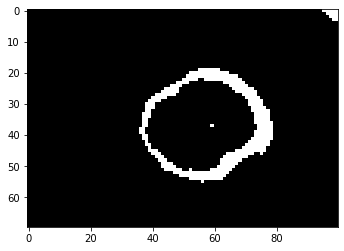

In [38]:
im_closing = skimage.morphology.binary_closing(image_otsu, selem = skimage.morphology.disk(radius))
plt.imshow(im_closing[180:250,0:100]);

### 5.1.3 Other binary filters

There are many other more complex filters that operate on binary images. For example one can determine the smallest convex shape enclosing ON pixels:

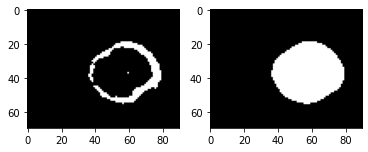

In [45]:
im_convex = skimage.morphology.convex_hull.convex_hull_image(image_otsu[180:250,0:90])
fig, ax = plt.subplots(1,2)
ax[0].imshow(image_otsu[180:250,0:90]);
ax[1].imshow(im_convex);

Or we can obtain the skeleton of these objects by using the skeletonize function:

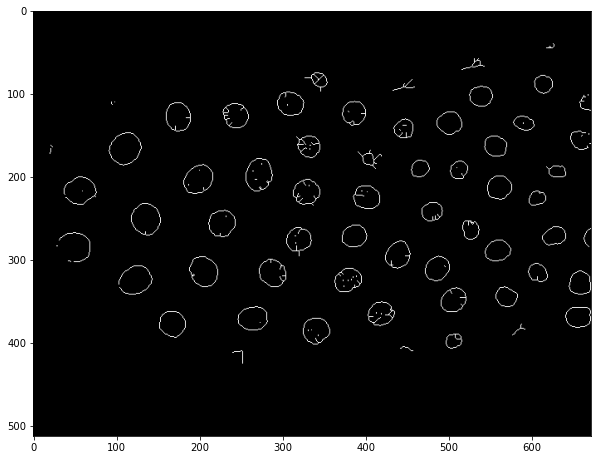

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(skimage.morphology.skeletonize(image_otsu));

## 5.2 Region properties

When a binary mask has been obtained, it is then possible to analyze it to define as objects each region of connected ON pixels, i.e. we can **label** the objects in the image. Using this labelled image, we can then measure the properties of all these objects or **regions**. We will show here how we can combine morphological operations, labeling and region measurements to isolate "interesting" objects from the noisy picture we previously obtained when using a local filter.

First we import the two essential function: ```skimage.measure.label``` and ```skimage.measure.regionprops_table``` (not that there is an alternative ```skimage.measure.regionprops``` function yielding the same measurements but in a less useful format).

In [48]:
from skimage.measure import label, regionprops_table

Remember that we previously used a local filter on the image. The advantage was that it nuclei preserved all nuclei, however at the cost of intense background signal:

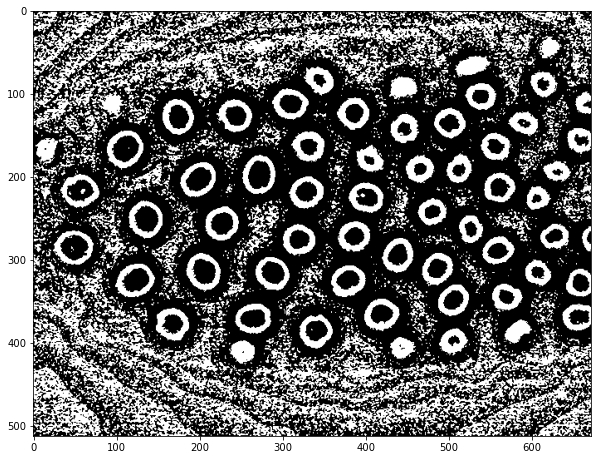

In [49]:
image_local_threshold = skimage.filters.threshold_local(image,block_size=51)
image_local = image > image_local_threshold

plt.figure(figsize=(10,10))
plt.imshow(image_local);

We see a large number of small white regions, and applying region measurements on such an image will be very inefficient. So we first perform an opening to suppress small regions:

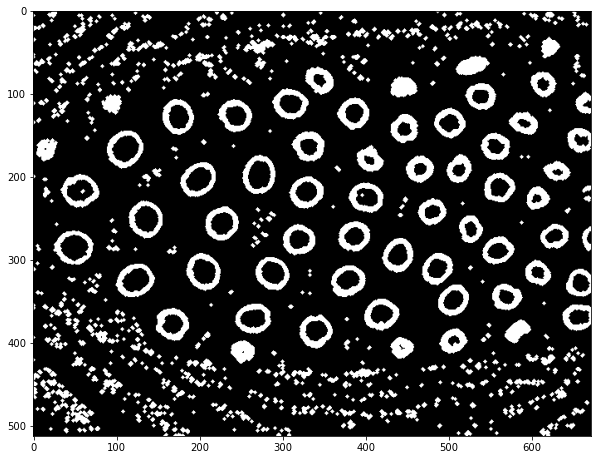

In [51]:
image_local_eroded = skimage.morphology.binary_opening(image_local, selem= skimage.morphology.disk(2))

plt.figure(figsize=(10,10))
plt.imshow(image_local_eroded);

To measure the properties of each region, we need a labeled image, i.e. an image in which each individual object is attributed a number. This is achieved using the skimage.measure.label() function. 

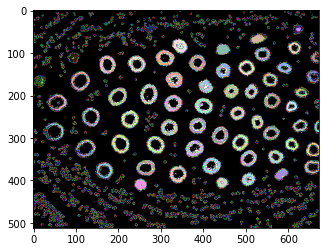

In [57]:
image_labeled = label(image_local_eroded)
plt.imshow(image_otsu)
plt.imshow(image_labeled, cmap = cmap);

In [16]:
image_labeled.max()

2902

The maximum label is 2902, i.e. we have 2902 separate objects in our mask. Now we can measure all the objects' properties. When using ```regionprops_table``` we need to specify which properties we want to measure (for a list see the [documentation](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops)). In general we can recover four types of information:

- geometric information on each shape (area, extent, perimeter, bounding box, etc.)
- vector information (pixel coordinates, centroid)
- region image information (average intensity, minimal intensity etc.)
- image-type information: e.g. a cropped image of each region to the size of its bounding-box

Here we will keep the area, the eccentricity (a "roundness" measure), and image, a cropped image of each region:

In [87]:
our_regions = regionprops_table(image_labeled, properties=('label', 'area','eccentricity','image','coords'))

The output is a dictionary with keys corresponding to the properties:

In [84]:
our_regions.keys()

dict_keys(['area', 'eccentricity', 'image', 'coords'])

For example the area key is a list of areas in pixels:

In [85]:
our_regions['area']

array([ 70,  24,  14,  58,  13,  13,  13, 101,  29,  13,  18,  18,  57,
         9,  37,  13,  52,  18,  69,  44,  18,  53,  29,  13,  32,  13,
        31,  13,  13,  13,  24,  13,  93,  13,  51,  39,  18, 119,  89,
        13,  18,  44,  51,  45,  68,  13,  13,  18,  13,  13,  52,  18,
        36,  31,  23,  27,  47,  13,  21,  97,  93,  13,  31,  25,  18,
        18,  77,  21,  13,  23,  24,  29,  18,  59,  48,  18, 195,  24,
        21,  24,  33,  13, 105,  23,  33,  18,  18,  35,  18,  33,  13,
        18,  18,  18, 372,  14,  13,  13,  13,  35, 362, 195,  41,  86,
        13,  21,  13,  13,  18,  13,  24,  13,  26,  18,  60,  42,  13,
        23,  13,  16,  13, 132,  39,  13,  41,  48, 102,  18,  31,  18,
        44,  24, 643,  84, 110,  13,  99,  76,  42,  13,  47,  31,  75,
        13,  13,  28,  13,  21,  18,  18,  21,  13,  42,  13, 659,  60,
        18,  23,  82,  33,  13,  13,  18,  28, 537,  13,  13,  13,  30,
        48,  28,  42,  48,  26,  34,  34,  18,  13, 613,  44,  1

Let us look at one region:

In [81]:
our_regions['area'][295]

736

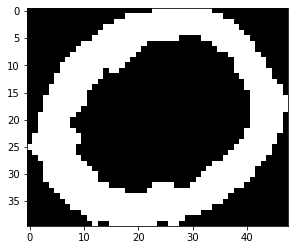

In [80]:
plt.imshow(our_regions['image'][295])

Since we now the labels of these regions, we can do things like recovering only certain labels in the image:

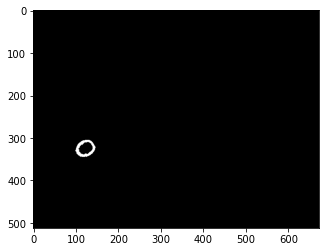

In [88]:
plt.imshow(image_labeled == our_regions['label'][295])

In general, one has an idea about the properties of the objects that are interesting. For example, here we know that objects contain at least several tens of pixels. Let us recover all the areas and look at their distributions:

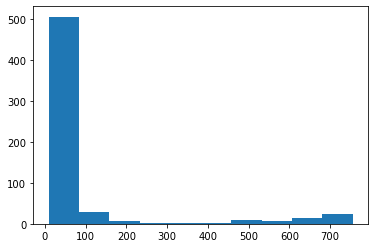

In [89]:
plt.hist(our_regions['area'])
plt.show()

We see that we have a large majority of regions that are very small and that we can discard. We can put a threshold and fill an empty mask with the conserved regions. We will show two ways of doing that. First, using the region coordinates:

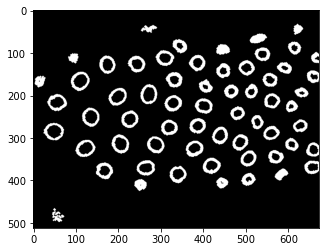

In [94]:
# create a zero image
newimage = np.zeros(image.shape)
# fill in using region coordinates
for x in range(len(our_regions['area'])):
    if our_regions['area'][x]>300:
        newimage[our_regions['coords'][x][:,0],our_regions['coords'][x][:,1]] = 1
#plot the result
plt.imshow(newimage)

For people interested in a more elegant solution, we can also select the labels to keep by numpy indexing. We first create a list of indices to conserve. If the *index* at position *index* should be discarded it is replaced by 0:

In [121]:
indices_to_keep = np.array([x if x-1 in np.argwhere(our_regions['area']>300)
 else 0 for x in range(our_regions['label'].max()+1)])

Now we can index that list with the labelled image. In that way each label in the image will take the value of the corresponding index in our list, and therefore labels that were discarded are replaced by zero. If this is not entirely clear, consult the [numpy indexing docs](https://numpy.org/doc/stable/user/basics.indexing.html)).

In [122]:
kept_labels = indices_to_keep[image_labeled]

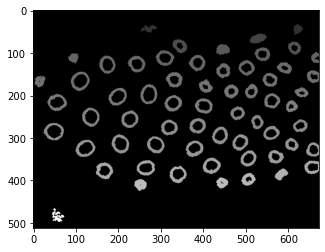

In [123]:
plt.imshow(kept_labels)

This is a success! We can verify how good the segmentation is by superposing it to the image.

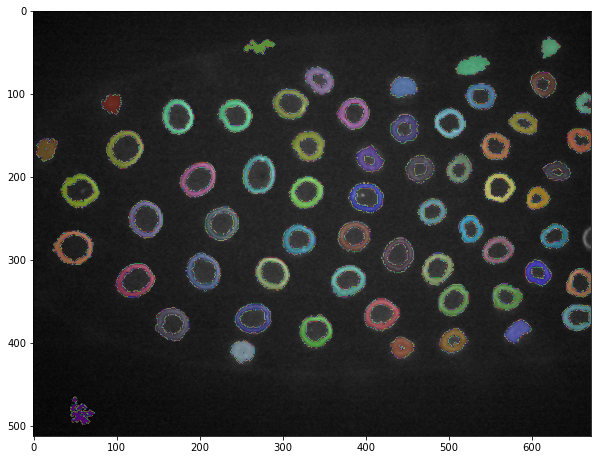

In [124]:
plt.figure(figsize=(10,10))
plt.imshow(image,cmap = 'gray')
plt.imshow(kept_labels,cmap = cmap);